In [0]:
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import argparse
import os
import torch.nn.functional as F
import torch.optim as optim
from collections import OrderedDict

In [0]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

In [11]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)
train_set = datasets.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]), download=True 
                      )
test_set = datasets.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]), download=True )

#train_set = datasets.MNIST(root=root, train=True, transform=trans, download=True)
#test_set = datasets.MNIST(root=root, train=False, transform=trans, download=True)

Using downloaded and verified file: ./train_32x32.mat
Using downloaded and verified file: ./test_32x32.mat


In [0]:
batch_size = 60

In [0]:
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                 dataset=test_set,
                 batch_size=batch_size,
                 shuffle=False)

In [0]:
def to_var(x, requires_grad=False, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=requires_grad, volatile=volatile)

In [0]:
def weight_prune(model, pruning_perc):
    all_weights = []
    for p in model.parameters():
        if len(p.data.size()) != 1:
            all_weights += list(p.cpu().data.abs().numpy().flatten())
             
    threshold = np.percentile(np.array(all_weights), pruning_perc)
    print(threshold)
    
    masks = []
    for p in model.parameters():
        if len(p.data.size()) != 1:
            pruned_inds = p.data.abs() > threshold
            masks.append(pruned_inds.float())
    
    return masks

In [0]:
def diff_init_weight_prune(model, pruning_perc):
    all_weights = []
    all_init_weights = []
    for p in model.parameters():
      if len(p.data.size()) != 1:
        all_weights += list(p.cpu().data.abs().numpy().flatten())
    
    for p in model.init_parameters():
      if len(p.data.size()) != 1:
        all_init_weights += list(p.cpu().data.abs().numpy().flatten())
    
    threshold = np.percentile(abs(np.array(all_init_weights)) - abs(np.array(all_weights)), pruning_perc)
    
    print(threshold)
    # generate mask
    masks = []
    for p, p_init in zip(model.parameters(), model.init_parameters()):
      if len(p.data.size()) != 1 and len(p_init.data.size()) != 1:
        pruned_inds = p_init.data.abs().cuda() - p.data.abs() > threshold
        masks.append(pruned_inds.float())
    
    return masks

In [0]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias)
        self.mask_flag = False
    
    def set_mask(self, mask):
        self.mask = mask
        mask_var = self.get_mask()
        self.weight.data = self.weight.data * mask_var.data
        self.mask_flag = True
    
    def get_mask(self):
        return to_var(self.mask, requires_grad=False)
    
    def forward(self, x):
        if self.mask_flag == True:
            mask_var = self.get_mask()
            weight = self.weight * mask_var
            return F.linear(x, weight, self.bias)
        else:
            return F.linear(x, self.weight, self.bias)

In [0]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, 
            kernel_size, stride, padding, dilation, groups, bias)
        self.mask_flag = False
    
    def set_mask(self, mask):
        self.mask = mask
        mask_var = self.get_mask()
        self.weight.data = self.weight.data * mask_var.data
        self.mask_flag = True
    
    def get_mask(self):
        return to_var(self.mask, requires_grad=False)
    
    def forward(self, x):
        if self.mask_flag == True:
            mask_var = self.get_mask()
            
            weight = self.weight * mask_var
            
            return F.conv2d(x, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)
        else:
            return F.conv2d(x, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

In [0]:
class LeNet5(nn.Module):
  def __init__(self):
      super(LeNet5, self).__init__()

      self.c1    = MaskedConv2d(3, 6, kernel_size=(5, 5))
      self.relu1 = nn.ReLU()
      self.s2    = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
      self.c3    = MaskedConv2d(6, 16, kernel_size=(5, 5))
      self.relu3 = nn.ReLU()
      self.s4    = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
      self.c5    = MaskedConv2d(16, 120, kernel_size=(5, 5))
      self.relu5 = nn.ReLU()
      
      self.fc = nn.Sequential(OrderedDict([
          ('f6', MaskedLinear(120, 84)),
          ('relu6', nn.ReLU()),
          ('f7', MaskedLinear(84, 10)),
          ('sig7', nn.LogSoftmax(dim=-1))
      ]))
      
      self.init_params = self.state_dict()
      
  def forward(self, img):
      output = self.c1(img)
      output = self.relu1(output)
      output = self.s2(output)
      output = self.c3(output)
      output = self.relu3(output)
      output = self.s4(output)
      output = self.c5(output)
      output = self.relu5(output)
      
      output = output.view(img.size(0), -1)
      output = self.fc(output)

      return output
    
  def set_masks(self, masks):
      self.c1.set_mask(masks[0])
      self.c3.set_mask(masks[1])
      self.c5.set_mask(masks[2])    
      self.fc.f6.set_mask(masks[3])
      self.fc.f7.set_mask(masks[4])
      
  def reset_parameters(self):
    self.load_state_dict(self.init_params)
    
  def init_parameters(self):
    for name in self.init_params.keys():
      yield self.init_params[name]

In [0]:
def compute_accuracy(model, loader):

    model.eval()
    
    num_correct, num_samples = 0, len(loader.dataset)
    for x, y in loader:
        x_var = to_var(x, volatile=True)
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()

    acc = float(num_correct) / num_samples

    return acc

In [0]:
#print("--- {}% parameters pruned ---".format(prune_rate(model)))

In [0]:
def train(model, loss_fn, optimizer, epochs, purge_epochs, purge_rate,
          loader_train, loader_val=None):

    model.train()
    
    loss_list = []
    accuracy_list = []
    
    for epoch in range(epochs):
        if ((epoch + 1) % purge_epochs == 0):
          if purge_rate != 0: 
            print("Purging...")     
            masks = diff_init_weight_prune(model, (1 - (1 - purge_rate / 100) ** ((epoch + 1) / purge_epochs)) * 100)
            
            model.reset_parameters()
            model.set_masks(masks)
            
            prune_rate(model)
            
        print('Starting epoch %d / %d' % (epoch + 1, epochs))
        av_loss = 0
        for t, (x, y) in enumerate(loader_train):
            x_var, y_var = to_var(x), to_var(y.long())

            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
            av_loss += loss.item()
        
        
        loss_list.append(av_loss / t)
        accuracy_list.append(compute_accuracy(model, test_loader))
          
    return loss_list, accuracy_list, purge_rate     

In [0]:
def prune_rate(model, verbose=True):
    total_nb_param = 0
    nb_zero_param = 0

    layer_id = 0

    for parameter in model.parameters():
      
        param_this_layer = 1
        for dim in parameter.data.size():
            param_this_layer *= dim
        total_nb_param += param_this_layer

        # only pruning linear and conv layers
        if len(parameter.data.size()) != 1:
            layer_id += 1
            zero_param_this_layer = \
                np.count_nonzero(parameter.cpu().data.numpy()==0)
            nb_zero_param += zero_param_this_layer

            if verbose:
                print("Layer {} | {} layer | {:.2f}% parameters pruned" \
                    .format(
                        layer_id,
                        'Conv' if len(parameter.data.size()) == 4 \
                            else 'Linear',
                        100.*zero_param_this_layer/param_this_layer,
                        ))
                
    pruning_perc = 100. * nb_zero_param/total_nb_param
    
    if verbose:
        print("Current pruning rate: {:.2f}%".format(pruning_perc))
    
    return pruning_perc

In [24]:
net = LeNet5()

if torch.cuda.is_available():
    print('CUDA enabled.')
    net.cuda()

print("--- Before retraining ---")
print("Accuracy: {}".format(compute_accuracy(net, test_loader)))

# Retrain
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001, 
                                weight_decay=0.0001)

loss, accuracy, _ = train(net, criterion, optimizer, epochs=20, 
                       purge_epochs=7, purge_rate=10, 
                       loader_train=train_loader)

print("--- After retraining ---")
print("Accuracy: {}".format(compute_accuracy(net, test_loader)))
prune_rate(net)

CUDA enabled.
--- Before retraining ---


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.


Accuracy: 0.07759680393362016
Starting epoch 1 / 20
Starting epoch 2 / 20
Starting epoch 3 / 20
Starting epoch 4 / 20
Starting epoch 5 / 20
Starting epoch 6 / 20
Purging...
-0.10853272676467897
Layer 1 | Conv layer | 16.44% parameters pruned
Layer 2 | Conv layer | 11.83% parameters pruned
Layer 3 | Conv layer | 9.00% parameters pruned
Layer 4 | Linear layer | 12.52% parameters pruned
Layer 5 | Linear layer | 27.98% parameters pruned
Current pruning rate: 9.96%
Starting epoch 7 / 20
Starting epoch 8 / 20
Starting epoch 9 / 20
Starting epoch 10 / 20
Starting epoch 11 / 20
Starting epoch 12 / 20
Starting epoch 13 / 20
Purging...
-0.08885966986417776
Layer 1 | Conv layer | 24.22% parameters pruned
Layer 2 | Conv layer | 23.50% parameters pruned
Layer 3 | Conv layer | 17.90% parameters pruned
Layer 4 | Linear layer | 21.71% parameters pruned
Layer 5 | Linear layer | 33.57% parameters pruned
Current pruning rate: 18.93%
Starting epoch 14 / 20
Starting epoch 15 / 20
Starting epoch 16 / 20
Sta

18.928813340644453

In [0]:
from matplotlib.colors import ListedColormap
from matplotlib import colors

def visualize(weights, title, figsize=None):
  plt.figure(figsize=figsize)
  

  cmap = ListedColormap(['k', 'w', 'r'])
  #cax = ax.matshow(x,cmap=cmap)
  data = weights.data.cpu().detach().abs().numpy().flatten()
  half = int(np.sqrt(data.size)) + 1
  data = np.concatenate((data, np.zeros(half * half - data.size)), axis=0)
  data = data.reshape(half, half)
  
  bounds=[0,0.000000000000001,0.5,1.0]
  norm = colors.BoundaryNorm(bounds, cmap.N)
  
  plt.imshow(data, cmap=cmap, norm=norm)
  plt.colorbar()
  plt.title(title)
  plt.axis('off')
  plt.tight_layout()

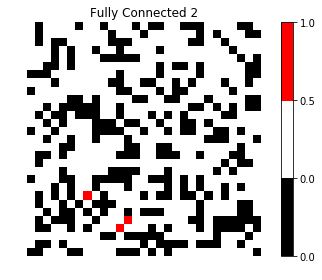

In [37]:
visualize(net.fc.f7.weight, title = "Fully Connected 2")

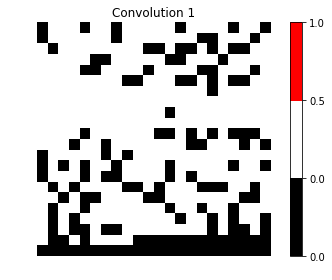

In [36]:
visualize(net.c1.weight, title = "Convolution 1")

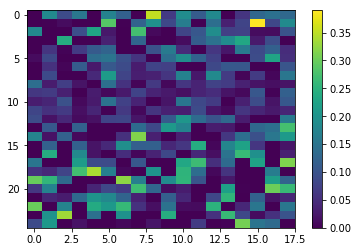

In [25]:
ractivations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    
    return hook

weights = net.c1.weight.data.cpu().abs().view(25, -1).numpy()
net.c1.register_forward_hook(get_activation('c1'))

x = torch.randn(1, 3, 32, 32)
x = x.cuda()
output = net(x)

im = plt.imshow(weights, interpolation='nearest', aspect='auto')
plt.colorbar()

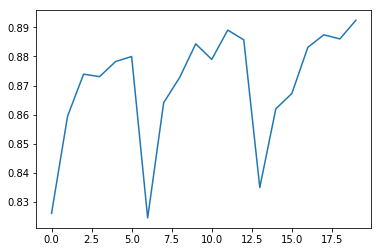

In [26]:
plt.plot(accuracy)

In [27]:
print(loss)

[0.8349632100614368, 0.4530246591653492, 0.3774478290657528, 0.33510805669500204, 0.3063915860518569, 0.2800439356536162, 1.0379936404404093, 0.4674890332656806, 0.3858972800926107, 0.3385272432240795, 0.3028519709365534, 0.278235163799197, 0.255851521202531, 0.9810279460349044, 0.45176791934082744, 0.3750842335588131, 0.32982399966262405, 0.29700814672425147, 0.27329533952059315, 0.25243784194720575]


In [28]:
print(accuracy)

[0.8260986478180701, 0.859480639213276, 0.8739244007375537, 0.8730792870313461, 0.8782652120467117, 0.8799938537185003, 0.8245620774431469, 0.8641287645974186, 0.8728103872157345, 0.8843346650276582, 0.8789950829748002, 0.889059618930547, 0.8857175783650891, 0.8350107559926244, 0.8620159803318992, 0.8672787338660111, 0.8831438229870928, 0.8874462200368777, 0.8860248924400738, 0.892440073755378]
